refer: https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

attention可视化的思路:
1. 通过hook获得特征层的grad,维度是(batch, 2048, 8, 8)
2. 然后对每个channel的grad求平均，维度是(batch, 2048)
3. 计算前向传播得到的特征图，维度是(batch, 2048, 8, 8)
4. 将第三步得到的特征图和第二步得到的平均后的grad做个加权求和，维度是(batch, 2048, 8, 8)
5. 将第四步加权求和后的(batch, 2048, 8, 8)按channel做平均，维度是(batch, 8, 8)，然后缩小到[0,1] 就是heatmap

## 加载基本模块

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

## 定义数据集

In [2]:
data_dir = '/home/yons/data/AID/AID'
import glob
image_path_list = glob.glob(os.path.join(data_dir, '*', '*'))
image_path_list.sort()
print(len(image_path_list))

categories = [d.name for d in os.scandir(data_dir) if d.is_dir()]
categories.sort()
print(len(categories))
class_to_idx = {categories[i]: i for i in range(len(categories))}
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}
print(class_to_idx)

import random
random.Random(10).shuffle(image_path_list) # 固定随机数种子，配合分类时的划分方式
image_path_list_train = image_path_list[:5000]
image_path_list_val = image_path_list[5000:]
print('train:', len(image_path_list_train))
print('val:', len(image_path_list_val))



10000
30
{'Airport': 0, 'BareLand': 1, 'BaseballField': 2, 'Beach': 3, 'Bridge': 4, 'Center': 5, 'Church': 6, 'Commercial': 7, 'DenseResidential': 8, 'Desert': 9, 'Farmland': 10, 'Forest': 11, 'Industrial': 12, 'Meadow': 13, 'MediumResidential': 14, 'Mountain': 15, 'Park': 16, 'Parking': 17, 'Playground': 18, 'Pond': 19, 'Port': 20, 'RailwayStation': 21, 'Resort': 22, 'River': 23, 'School': 24, 'SparseResidential': 25, 'Square': 26, 'Stadium': 27, 'StorageTanks': 28, 'Viaduct': 29}
train: 5000
val: 5000


## 加载保存好的模型

In [3]:
import torchvision
import torch.nn as nn
model = torchvision.models.resnext50_32x4d(pretrained=True)
for i, layer in enumerate(model.children()):
    if i < 6:
        for param in layer.parameters():
            param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, 30))
net = model.cuda()
net = nn.DataParallel(net)

In [4]:
import torch
version = '0.1'
log_dir = 'AID-quickstart.log'
save_dir = os.path.join(log_dir, version)
save_path = os.path.join(save_dir, 'best_acc.pth')
checkpoint = torch.load(save_path)
net.load_state_dict(checkpoint['net'])
print(checkpoint['epoch'], checkpoint['loss'], checkpoint['acc'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

13 0.3272677581757307 0.92421875


## 定义数据加载接口

In [6]:
mean = [0.3989299, 0.41072574, 0.36983183]
std = [0.14689957, 0.13350782, 0.12862574]
from torchvision import transforms
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

from torchvision import datasets
from torch.utils.data import DataLoader

batch_size = 128

from torch.utils.data import Dataset
from PIL import Image

class SceneDataset(Dataset):

    def __init__(self, samples, transform, notebook=False):
        self.transform = transform
        self.samples = samples
        self.get_item = self.get_item_from_path
        print(len(self.samples))

    def get_item_from_path(self, index):
        path, target = self.samples[index]
        with open(path, 'rb') as f:
            img = Image.open(f).convert('RGB')
        return img, target

    def __getitem__(self, index):
        sample, target = self.get_item(index)
        sample = self.transform(sample)
        return sample, target

    def __len__(self):
        return len(self.samples)
    
    
data = {
    'train':
    SceneDataset([(x, class_to_idx[x.split('/')[-2]]) for x in image_path_list_train], transform=image_transforms['train']),
    'val':
    SceneDataset([(x, class_to_idx[x.split('/')[-2]]) for x in image_path_list_val], transform=image_transforms['val']),
}
dataloader_val = DataLoader(data['val'], batch_size=1, shuffle=False)
dataiter_val = iter(dataloader_val)

5000
5000


## 定义用于计算卷积的模块

In [7]:
net_single = list(net.children())[0]

from torchvision import models
class ResNetCam(nn.Module):
    def __init__(self):
        super(ResNetCam, self).__init__()
        
        # get the pretrained VGG19 network
        self.resnet = net_single

        
        # disect the network to access its last convolutional layer
        self.features_conv = nn.Sequential(*list(self.resnet.children())[:8])
        
        # get the max pool of the features stem
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # get the classifier of the vgg19
        self.fc = self.resnet.fc
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        print(x.shape)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.fc(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)
resNetCam = ResNetCam()
_ = resNetCam.eval()

## attention可视化

torch.Size([1, 2048, 8, 8])


Bridge


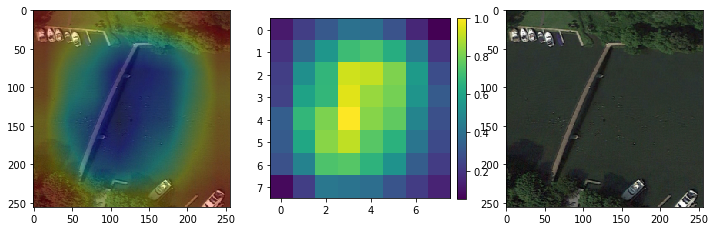

In [45]:
img, _ = next(dataiter_val)

# get the most likely prediction of the model
pred = resNetCam(img.cuda())

index = pred.argmax(dim=1).item()

pred[:, index].backward()

# pull the gradients out of the model
gradients = resNetCam.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = resNetCam.get_activations(img.cuda()).detach()


# weight the channels by corresponding gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = heatmap.cpu()
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)



image = img[0].numpy().transpose((1, 2, 0))
image = np.array(std) * image + np.array(mean)
image = np.clip(image, 0, 1)
image = np.uint8(255*image)

import cv2
heatmap_resize = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]))
heatmap_resize = np.uint8(255 * heatmap_resize)
heatmap_resize = cv2.applyColorMap(heatmap_resize, cv2.COLORMAP_JET)
superimposed_img = heatmap_resize * 0.4 + image
superimposed_img = superimposed_img / np.max(superimposed_img)

fig, axes = plt.subplots(1,3,figsize=(12,4))
axes[0].imshow(superimposed_img)

tmp = heatmap.squeeze().numpy()
im = axes[1].imshow(tmp, interpolation='nearest')
axes[1].figure.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

axes[2].imshow(image)

print(idx_to_class[index])